This post builds on, and updates, [an older blog post](https://greglandrum.github.io/rdkit-blog/posts/2021-08-03-generalized-substructure-search.html) as well as some material from the 2024 RDKit UGM [What's New session](https://github.com/rdkit/UGM_2024/blob/main/Notebooks/Greg_WhatsNew.ipynb).
It's a tutorial on some functionality for making substructure searching considerably more flexible that we call "Generalized Substructure Search".

I will show how use to use generalized substructure search with both a `SubstructLibrary` and the RDKit PostgreSQL cartridge.

In [1]:
import copy
import json
from rdkit import Chem
from rdkit.Chem import rdGeneralizedSubstruct
from rdkit.Chem import rdTautomerQuery
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.minFontSize = 10
Draw.SetComicMode(IPythonConsole.drawOptions)
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import rdkit
print(rdkit.__version__)


2024.09.5


In [2]:
%load_ext sql

Load a `SubstructLibrary` created using ChEMBL 35. I do this using Charles Hoyt's The [`chembl_downloader`](https://github.com/cthoyt/chembl-downloader) Python package to handle downloading the ChEMBL SDF data.
For reference, on my 2.5 year old linux box, processing the 2.4 million molecules took ~990 seconds.

The code used to construct this is:

```python
chembl_version="35"

from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import rdSubstructLibrary
import pickle, time
import gzip
import chembl_downloader

RDLogger.DisableLog("rdApp.warning")
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.TautomerPatternHolder(1024)
keys = rdSubstructLibrary.KeyFromPropHolder() 
library = rdSubstructLibrary.SubstructLibrary(mols,fps, keys)
nats = []
with chembl_downloader.supplier(version=chembl_version) as suppl:
    t1=time.time()
    for i,mol in enumerate(suppl):
        if not ((i+1)%50000):
            print(f"Processed {i+1} molecules in {(time.time()-t1):.1f} seconds")
        if mol is None or mol.GetNumAtoms()>75:
            continue
        library.AddMol(mol)
        nats.append(mol.GetNumHeavyAtoms())
t2=time.time()
print(f"That took {t2-t1:.2f} seconds. The library has {len(library)} molecules.")
with open(f'../data/chembl{chembl_version}_ssslib.pkl','wb+') as outf:
    pickle.dump(library,outf)


# we want to be able to use the number of heavy atoms as a search order:
nats = sorted([(x,i) for i,x in enumerate(nats)])
order = [y for x,y in nats]
# append that to the pickle file with the substruct lib:
with open(f'../data/chembl{chembl_version}_ssslib.pkl','ab') as outf:
    pickle.dump(order,outf)
    
```

In [3]:
import pickle
with open('../data/chembl35_ssslib.pkl','rb') as inf:
    sslib = pickle.load(inf)
    order = pickle.load(inf)
print(f'SubstructLibrary loaded with {len(sslib)} molecules')

SubstructLibrary loaded with 2430167 molecules


# Advanced query basics

(Yes, I am laughing as I write this)

Start with a query including a variable attachment point:

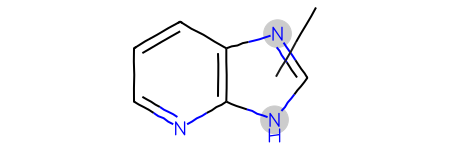

In [4]:
qmb = '''
  Mrv2108 08012107372D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 11 11 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -2.4167 7.8734 0 0
M  V30 2 C -3.7503 7.1034 0 0
M  V30 3 C -3.7503 5.5633 0 0
M  V30 4 N -2.4167 4.7933 0 0
M  V30 5 C -1.083 5.5633 0 0
M  V30 6 C -1.083 7.1034 0 0
M  V30 7 N 0.3973 7.5279 0 0
M  V30 8 N 0.3104 5.0377 0 0
M  V30 9 C 1.2585 6.2511 0 0
M  V30 10 * 0.3539 6.2828 0 0
M  V30 11 C 1.5089 8.2833 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 6
M  V30 8 1 5 8
M  V30 9 1 8 9
M  V30 10 2 7 9
M  V30 11 1 10 11 ENDPTS=(2 8 7) ATTACH=ANY
M  V30 END BOND
M  V30 END CTAB
M  END
'''
qry = Chem.MolFromMolBlock(qmb)
qry

If we just use that query with the substruct library we don't get the expected results:

1000 results


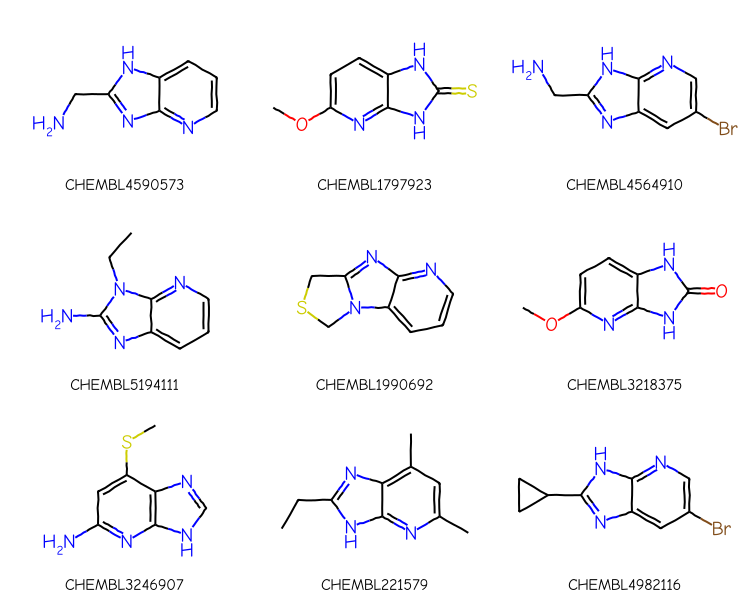

In [5]:
# change the sort order of the substruct library so that
# we get the matches in order of increasing number of heavy atoms
sslib.SetSearchOrder(order)
mids = sslib.GetMatches(qry)
print(f'{len(mids)} results')
ms = [sslib.GetMolHolder().GetMol(x) for x in mids[:9]]
legends = [sslib.GetKeyHolder().GetKey(x) for x in mids[:9]]
Draw.MolsToGridImage(ms,legends=legends,subImgSize=(250,200))

Repeat that query using the cartridge and my local install of ChEMBL35

1000 rows affected.
1000 matches


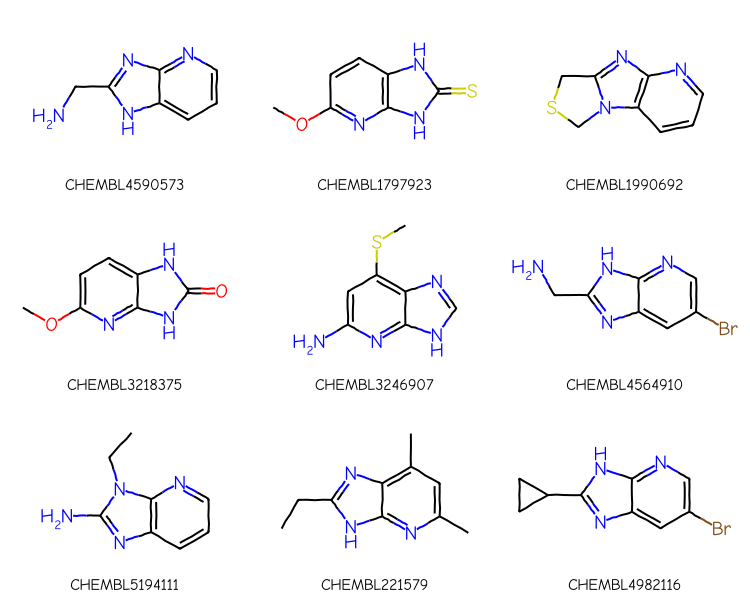

In [6]:
matches = %sql postgresql://localhost/chembl_35 \
    select chembl_id,mol_send(m) from rdk.mols \
        join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
        join compound_properties using (molregno) \
        where m@> mol_from_ctab(:qmb) \
    order by (heavy_atoms,chembl_id) limit 1000
    
print(f'{len(matches)} matches')
    
mols = [Chem.Mol(y.tobytes()) for x,y in matches][:9]
legends = [x for x,y in matches]
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200))

The ordering of the results is different, but the same molecules, most of which don't match what we intended, are there.

In order to use the advanced query feature (the link node) in the search, we need to construct an extended query mol and then pass that to the substruct library:

1000 matches


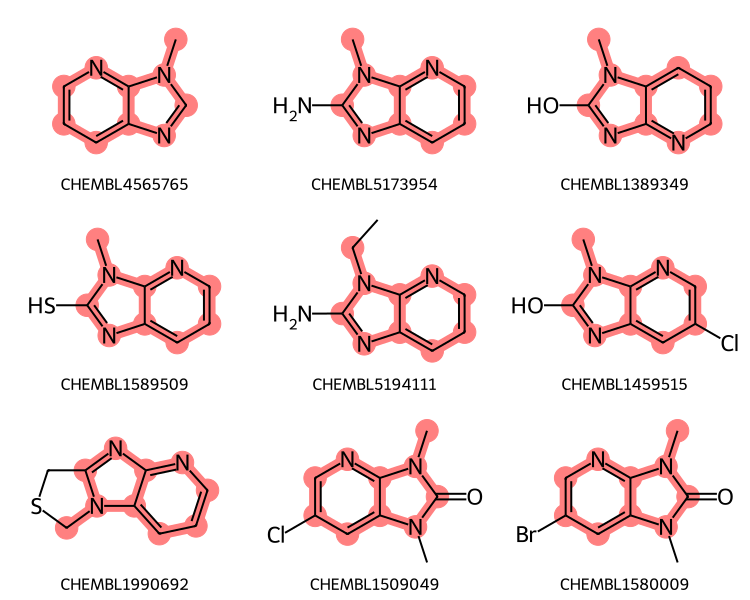

In [7]:
xqry = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry)
matches = sslib.GetMatches(xqry)
print(f'{len(matches)} matches')
mols = [sslib.GetMol(x) for x in matches][:9]
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]

# get the actual matching atoms from each molecule 
# so we can highlight them:
highlights = []
for mol in mols:
    highlights.append(rdGeneralizedSubstruct.MolGetSubstructMatch(mol,xqry))
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]
dopts = Draw.MolDrawOptions()
dopts.useBWAtomPalette()
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200),
                     highlightAtomLists=highlights,drawOptions=dopts)


Repeat that using the cartridge. The key here is the function `mol_to_xqmol()`:

1000 rows affected.
1000 matches


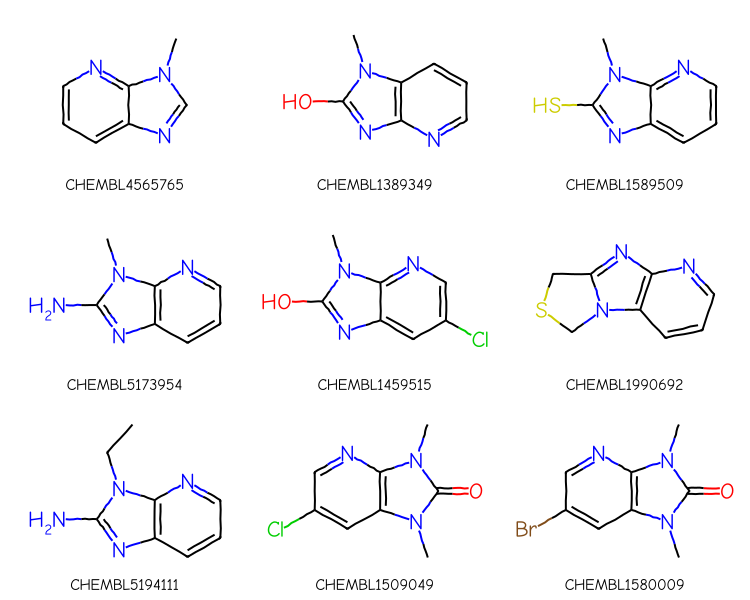

In [8]:
matches = %sql postgresql://localhost/chembl_35 \
    select chembl_id,mol_send(m) from rdk.mols \
        join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
        join compound_properties using (molregno) \
        where m@> mol_to_xqmol(mol_from_ctab(:qmb)) \
    order by (heavy_atoms,chembl_id) limit 1000
    
print(f'{len(matches)} matches')
    
mols = [Chem.Mol(y.tobytes()) for x,y in matches][:9]
legends = [x for x,y in matches]
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200))

Many of those include sidechains (or even other rings in the case of CHEMBL1990692) attached to the core. We can limit the results to only have substitutions at two the two positions tagged in the query using the `adjustQueryProperties` flag. You can find more information about this function in an [old blog post](https://rdkit.blogspot.com/2016/07/tuning-substructure-queries-ii.html)

> Memo to myself: update that post!


186 matches


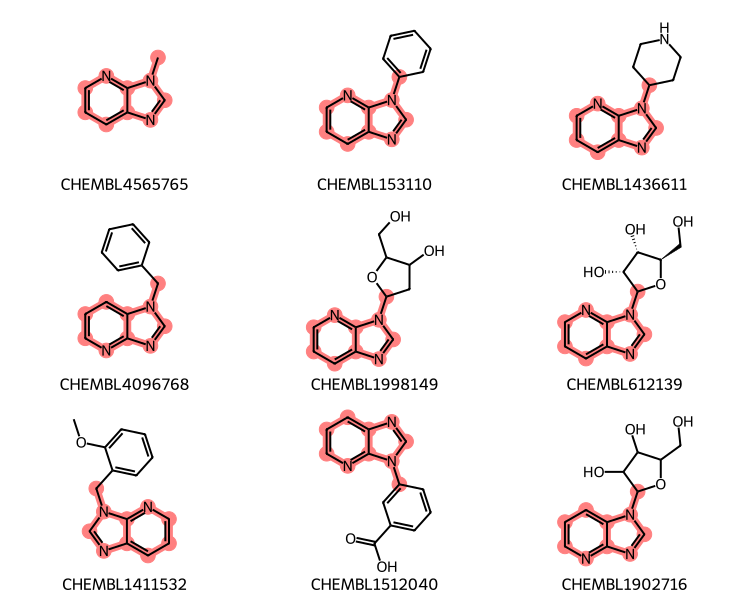

In [9]:
aqps = Chem.AdjustQueryParameters()
aqps.adjustHeavyDegree = True
aqps.adjustHeavyDegreeFlags = Chem.AdjustQueryWhichFlags.ADJUST_IGNORECHAINS
xqry = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry,adjustQueryProperties=True,
                                                     adjustQueryParameters=aqps)
matches = sslib.GetMatches(xqry)
print(f'{len(matches)} matches')
mols = [sslib.GetMol(x) for x in matches][:9]
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]

highlights = []
for mol in mols:
    highlights.append(rdGeneralizedSubstruct.MolGetSubstructMatch(mol,xqry))
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]
dopts = Draw.MolDrawOptions()
dopts.useBWAtomPalette()
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200),
                     highlightAtomLists=highlights,drawOptions=dopts)


Now do the same thing with the cartridge:

190 rows affected.
190 matches


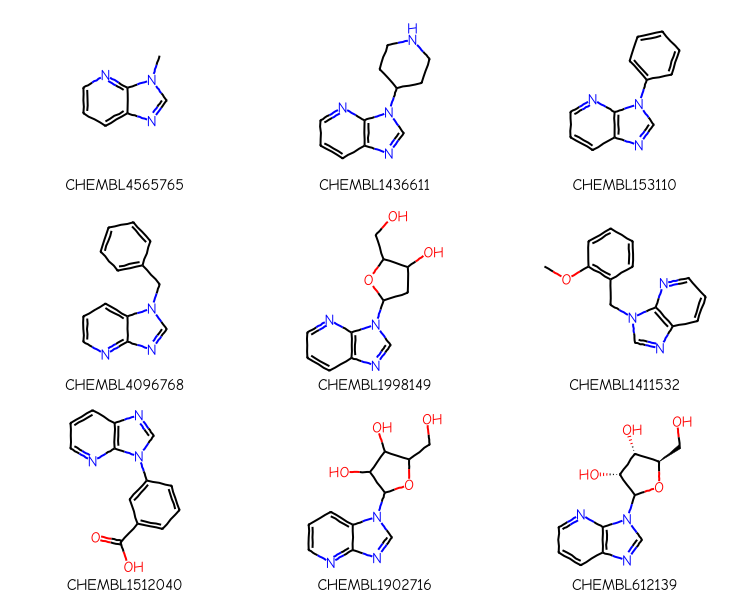

In [10]:
params = json.dumps({"adjustHeavyDegree":True,"adjustHeavyDegreeFlags":"IGNORECHAINS"})
matches = %sql postgresql://localhost/chembl_35 \
    select chembl_id,mol_send(m) from rdk.mols \
        join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
        join compound_properties using (molregno) \
        where m@> mol_to_xqmol(mol_from_ctab(:qmb),true,true,true,:params) \
    order by (heavy_atoms,chembl_id) limit 1000
    
print(f'{len(matches)} matches')
    
mols = [Chem.Mol(y.tobytes()) for x,y in matches][:9]
legends = [x for x,y in matches]
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200))

# Using generic atoms

For the next query we will combine a generic atom along with a link node (a position in the molecule which can have varying numbers of atoms)

There's more information, including a list of supported atom types, in the [RDKit book](https://www.rdkit.org/docs/RDKit_Book.html#generic-markush-queries-in-substructure-matching)

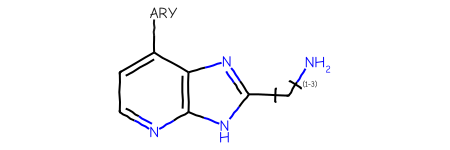

In [11]:
qmb = '''
  Mrv2401 02062512582D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 12 13 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C -2.4167 7.8733 0 0
M  V30 2 C -3.7503 7.1033 0 0
M  V30 3 C -3.7503 5.5632 0 0
M  V30 4 N -2.4167 4.7932 0 0
M  V30 5 C -1.083 5.5632 0 0
M  V30 6 C -1.083 7.1033 0 0
M  V30 7 N 0.3973 7.5278 0 0
M  V30 8 N 0.3104 5.0376 0 0
M  V30 9 C 1.2585 6.251 0 0
M  V30 10 C 2.7975 6.1973 0 0
M  V30 11 N 3.6136 7.5032 0 0
M  V30 12 * -2.4167 9.4133 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 6
M  V30 8 1 5 8
M  V30 9 1 8 9
M  V30 10 2 7 9
M  V30 11 1 9 10
M  V30 12 1 10 11
M  V30 13 1 1 12
M  V30 END BOND
M  V30 LINKNODE 1 3 2 10 9 10 11
M  V30 BEGIN SGROUP
M  V30 1 SUP 0 ATOMS=(1 12) SAP=(3 12 1 1) XBONDS=(1 13) LABEL=ARY ESTATE=E
M  V30 END SGROUP
M  V30 END CTAB
M  END
'''
qry = Chem.MolFromMolBlock(qmb)

# we currently have to do some contortions in order to show labels for the Sgroups:
lbls = []
for sgs in Chem.GetMolSubstanceGroups(qry):
    if sgs.GetProp('TYPE') == 'SUP':
        lbls.append((sgs.GetAtoms()[0],sgs.GetProp("LABEL")))

# convert the Sgroups into queries:        
Chem.SetGenericQueriesFromProperties(qry)

# now apply the labels
for idx,lbl in lbls:
    qry.GetAtomWithIdx(idx).SetProp('atomLabel',lbl)
                    

qry

2 matches


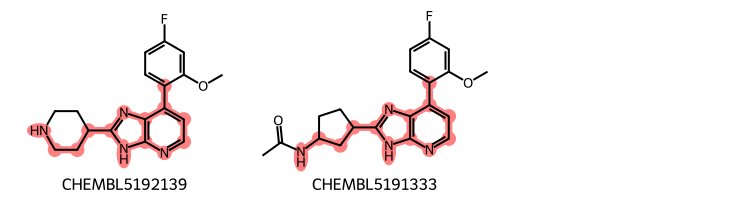

In [12]:
aqps = Chem.AdjustQueryParameters()
aqps.adjustHeavyDegree = True
aqps.adjustHeavyDegreeFlags = Chem.AdjustQueryWhichFlags.ADJUST_IGNORECHAINS

xqry = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry,adjustQueryProperties=True,
                                                     adjustQueryParameters=aqps)
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(xqry, params)
print(f'{len(matches)} matches')

mols = [sslib.GetMol(x) for x in matches][:9]
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]

highlights = []
for mol in mols:
    highlights.append(rdGeneralizedSubstruct.MolGetSubstructMatch(mol,xqry))
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]
dopts = Draw.MolDrawOptions()
dopts.useBWAtomPalette()
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200),
                     highlightAtomLists=highlights,drawOptions=dopts)



We can use generic queries in the cartridge by explicitly calling `mol_adjust_query_properties()` and including `"setGenericQueryFromProperties":true` in its arguments (we should clean that up, and make `mol_to_xqmol()` support the extra work), and by using the `@>>` operator to search instead of the normal `@>` substructure search operator.



2 rows affected.
2 matches


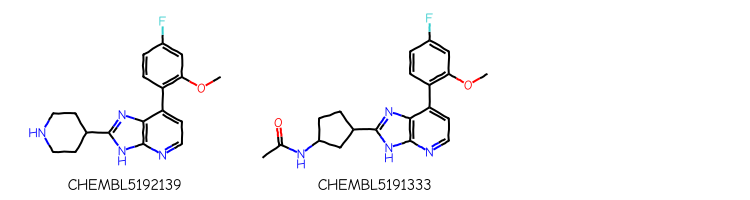

In [13]:
params = json.dumps({"adjustHeavyDegree":True,
                     "adjustHeavyDegreeFlags":"IGNORECHAINS",
                     "setGenericQueryFromProperties":True})
matches = %sql postgresql://localhost/chembl_35 \
    select chembl_id,mol_send(m) from rdk.mols \
        join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
        join compound_properties using (molregno) \
        where m@>> mol_to_xqmol(mol_adjust_query_properties(mol_from_ctab(:qmb),:params)) \
    order by (heavy_atoms,chembl_id) limit 1000
    
print(f'{len(matches)} matches')
    
mols = [Chem.Mol(y.tobytes()) for x,y in matches][:9]
legends = [x for x,y in matches]
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200))

If we don't use the generic matchers, we get additional results:

4 matches


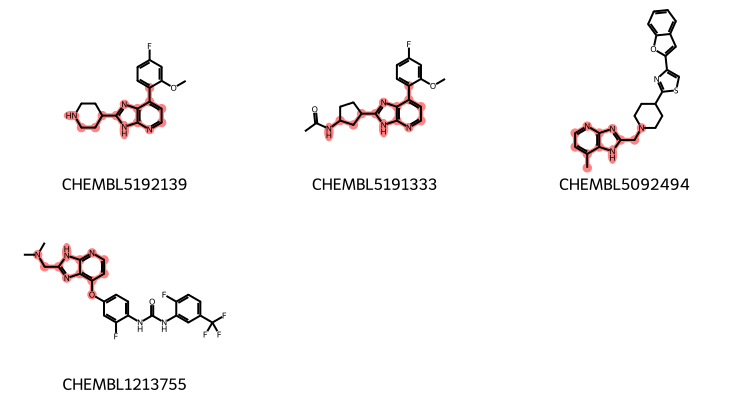

In [14]:
matches = sslib.GetMatches(xqry)
print(f'{len(matches)} matches')

mols = [sslib.GetMol(x) for x in matches][:9]
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]

highlights = []
for mol in mols:
    highlights.append(rdGeneralizedSubstruct.MolGetSubstructMatch(mol,xqry))
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]
dopts = Draw.MolDrawOptions()
dopts.useBWAtomPalette()
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200),
                     highlightAtomLists=highlights,drawOptions=dopts)


# Tautomer insensitivity

We haven't seen it in the examples so far, but the results are being done with a tautomer insensitive search - it finds molecules where a tautomer could match the query even if the molecule itself may not directly match.

Here's a query incorporating both a variable attachment point and a link node which demonstrates this:

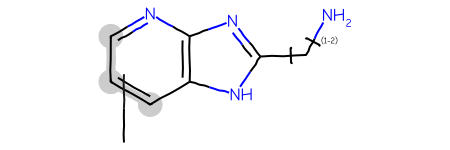

In [15]:
qmb = '''qry 
  Mrv2305 09052314502D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 13 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N -4.75 1.9567 0 0
M  V30 2 C -6.0837 1.1867 0 0
M  V30 3 C -6.0837 -0.3534 0 0
M  V30 4 C -4.75 -1.1234 0 0
M  V30 5 C -3.4163 -0.3534 0 0
M  V30 6 C -3.4163 1.1867 0 0
M  V30 7 N -1.9692 1.7134 0 0
M  V30 8 N -1.8822 -0.7768 0 0
M  V30 9 C -1.0211 0.4999 0 0
M  V30 10 C 0.5179 0.5536 0 0
M  V30 11 N 1.2409 1.9133 0 0
M  V30 12 * -5.6391 -0.0967 0 0
M  V30 13 C -5.6391 -2.4067 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 8 9
M  V30 8 1 7 6
M  V30 9 1 5 8
M  V30 10 2 7 9
M  V30 11 1 9 10
M  V30 12 1 10 11
M  V30 13 1 12 13 ENDPTS=(3 4 3 2) ATTACH=ANY
M  V30 END BOND
M  V30 LINKNODE 1 2 2 10 9 10 11
M  V30 END CTAB
M  END'''

qry = Chem.MolFromMolBlock(qmb)

qry

20 matches


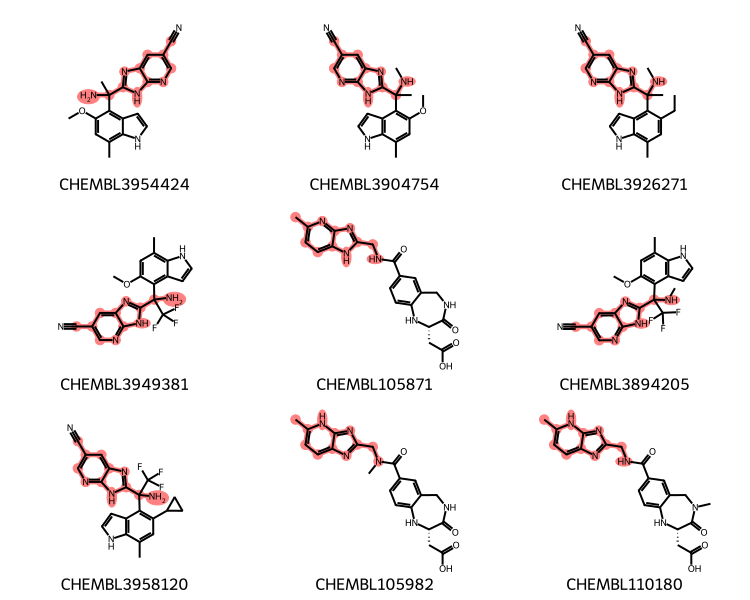

In [16]:
aqps = Chem.AdjustQueryParameters()
aqps.adjustHeavyDegree = True
aqps.adjustHeavyDegreeFlags = Chem.AdjustQueryWhichFlags.ADJUST_IGNORECHAINS

xqry = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry,adjustQueryProperties=True,
                                                     adjustQueryParameters=aqps)
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(xqry, params)
print(f'{len(matches)} matches')

mols = [sslib.GetMol(x) for x in matches][:9]
highlights = []
for mol in mols:
    highlights.append(rdGeneralizedSubstruct.MolGetSubstructMatch(mol,xqry))
legends = [sslib.GetKeyHolder().GetKey(x) for x in matches]
dopts = Draw.MolDrawOptions()
dopts.useBWAtomPalette()
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(250,200),
                     highlightAtomLists=highlights,drawOptions=dopts)


Molecules CHEMBL105982 and CHEMBL110180, which are drawn with a different tautomer of the ring system we're lookin for, would not be found using a standard substructure search:

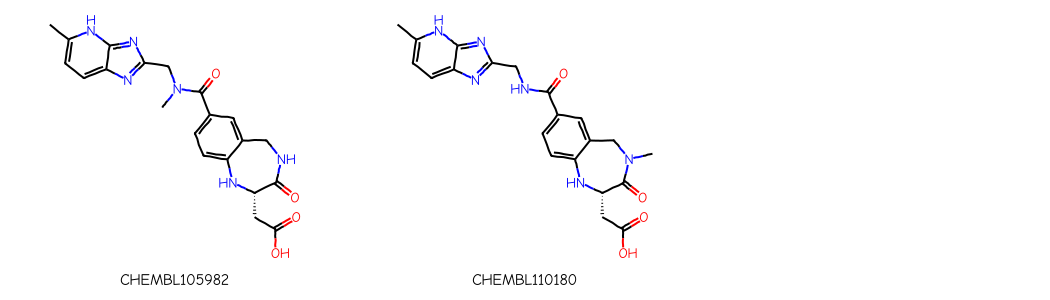

In [18]:
Draw.MolsToGridImage(mols[7:9],legends=legends[7:9], subImgSize=(350,300))

In [20]:
mols[7].HasSubstructMatch(qry),mols[8].HasSubstructMatch(qry)

(False, False)

# Supported query features

In addition to the link nodes and variable attachment points demonstrated above, the extended query mol also supports SRUs (repeat units with a specified range of repeats, these are similar to link nodes but can support multiple atoms).

The list of supported generic queries can be found in the [RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html#generic-markush-queries-in-substructure-matching)

# Creating advanced queries

## Sketchers

At the time I wrote this post, none of the freely available chemical sketchers I was aware of were able to create either link nodes or variable attachment points. The open sketchers like ketcher are steadily improving, but, at least as far as I can tell, they don't support these advanced query features. I drew all the queries for the post using ChemAxon's MarvinSketch, which has been my go-to sketcher for years. It's cross-platform, not insanely expensive, and generaly quite good. Biovia Draw, as you'd expect, can also deal with all of these features (at least it used to back when I still had a license. I stopped paying for that one a few years ago since I wasn't using it). I haven't used any of the other commercial chemical sketchers recently, so I can't comment on their support.

## By hand


If you know SMARTS, it's pretty easy to add either link nodes or variable attachment points to [CXSMARTS](https://docs.chemaxon.com/display/docs/formats_chemaxon-extended-smiles-and-smarts-cxsmiles-and-cxsmarts.md); here's some documentation on the subset of CXSMARTS that the RDKit [currently supports](https://www.rdkit.org/docs/RDKit_Book.html#cxsmiles-cxsmarts-extensions)

Here's an example for a link node. Here you need to provide the index (all indices in CXSMARTS are zero-based) for the atom that is the link node along with the possible repeat counts:

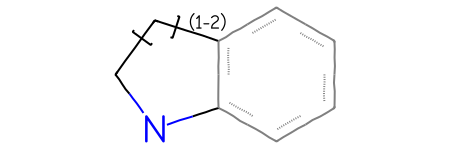

In [21]:
m = Chem.MolFromSmarts('[#6]-1-[#6]-c2ccccc2-[#7]-1 |LN:1:1.2|')
m

For variable attachment points you provide the index of the multi-center attachment point (the atom that will not be actual enumerated molecule) and the indices of the atoms that are bonded to the attachment point's neighbor:

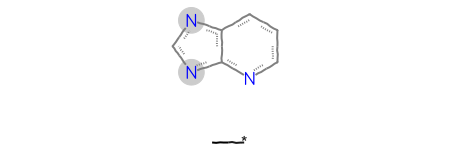

In [22]:
m = Chem.MolFromSmarts('[#6]-*.c1nc2cccnc2n1 |m:1:3.10|')
m

Notice that we currently do a pretty crappy job of generating coordinates for these multi-center attachments. That's something we need to work on at some point in the future.

SRUs (repeat units that can include multiple atoms) are a bit trickier to provide by hand, but still doable:

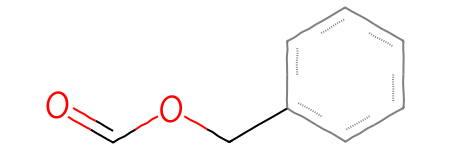

In [27]:
m = Chem.MolFromSmarts('c1ccccc1-[#6]-[#8]-C=O |Sg:n:6,7:2-4:ht:::|')
m

Note that the current rendering code does not automagically insert missing brackets (something we should fix), but we can see that the correct substance group type has been added:

In [28]:
sgs = Chem.GetMolSubstanceGroups(m)
sg = sgs[0]
sg.GetPropsAsDict()

{'TYPE': 'SRU',
 '_cxsmilesindex': 0,
 'LABEL': '2-4',
 'CONNECT': 'HT',
 'XBHEAD': <rdkit.rdBase._vectj at 0x78dfc975fb40>,
 'XBCORR': <rdkit.rdBase._vectj at 0x78dfc975f840>,
 'index': 1}

Here's the same query provided as a mol block, so we can see the brackets:

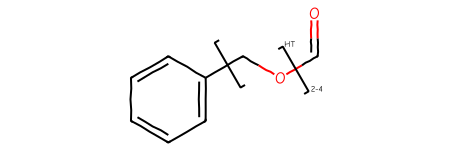

In [29]:
qmb = '''
  Mrv2401 02082507292D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 10 10 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C -9.3703 -7.3117 0 0
M  V30 2 C -10.7039 -8.0817 0 0
M  V30 3 C -10.7039 -9.6218 0 0
M  V30 4 C -9.3703 -10.3918 0 0
M  V30 5 C -8.0366 -9.6218 0 0
M  V30 6 C -8.0366 -8.0817 0 0
M  V30 7 C -6.7029 -7.3117 0 0
M  V30 8 O -5.3692 -8.0818 0 0
M  V30 9 C -4.0357 -7.3118 0 0
M  V30 10 O -4.0357 -5.7718 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 6 7
M  V30 8 1 7 8
M  V30 9 1 8 9
M  V30 10 2 9 10
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 SRU 0 ATOMS=(2 7 8) XBONDS=(2 7 9) BRKXYZ=(9 -5.2821 -6.9645 0 -
M  V30 -4.3581 -8.5649 0 0 0 0) BRKXYZ=(9 -6.7901 -8.429 0 -7.7141 -6.8286 0 -
M  V30 0 0 0) CONNECT=HT LABEL="2-4"
M  V30 END SGROUP
M  V30 END CTAB
M  END
'''
qry = Chem.MolFromMolBlock(qmb)
qry

And a quick demonstration that it actually works:

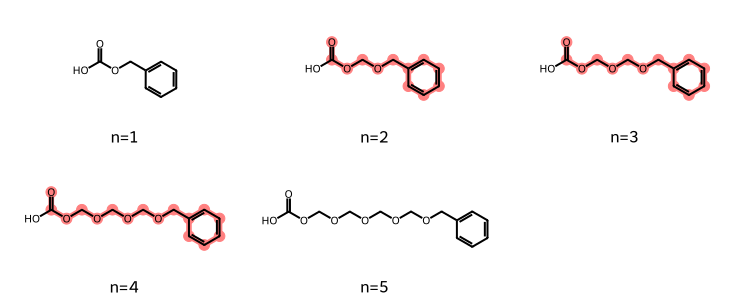

In [34]:
tmols = [Chem.MolFromSmiles(smi) for smi in ('c1ccccc1COC(=O)O','c1ccccc1COCOC(=O)O',
                                             'c1ccccc1COCOCOC(=O)O','c1ccccc1COCOCOCOC(=O)O',
                                            'c1ccccc1COCOCOCOCOC(=O)O')]
xqry = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry)

highlights = []
for mol in tmols:
    highlights.append(rdGeneralizedSubstruct.MolGetSubstructMatch(mol,xqry))
dopts = Draw.MolDrawOptions()
dopts.useBWAtomPalette()
legends = [f'n={i}' for i in range(1,6)]
Draw.MolsToGridImage(tmols,subImgSize=(250,150),legends=legends,
                     highlightAtomLists=highlights,drawOptions=dopts)